In [1]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
# init sagemaker
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name

In [3]:
# config S3
bucket = 'solar-radiation-forecast'
prefix = 'sagemaker/deepar-monthly-solar-radiation'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [4]:
train_key = 'train.json'
test_key = 'test.json'

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

In [5]:
# we configure the container image to be used for the region that we are running in
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [6]:
freq = 'M'
prediction_length = 24
context_length = 36

In [7]:
# train a model
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    base_job_name='POC-deepar-solar-forecast-model',
    output_path=output_path
)

In [8]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": freq, # daily series
    "context_length": str(prediction_length),
    "prediction_length": str(prediction_length), # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

In [9]:
estimator.set_hyperparameters(**hyperparameters)

In [10]:
print(train_path)
print(test_path)
print(output_path)

s3://solar-radiation-forecast/sagemaker/deepar-monthly-solar-radiation/train/train.json
s3://solar-radiation-forecast/sagemaker/deepar-monthly-solar-radiation/test/test.json
s3://solar-radiation-forecast/sagemaker/deepar-monthly-solar-radiation/output


In [11]:
data_channels = {"train": train_path, "test": test_path}

In [12]:
%%time
estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554


2019-01-09 07:52:40 Starting - Starting the training job...
2019-01-09 07:52:42 Starting - Launching requested ML instances......
2019-01-09 07:53:49 Starting - Preparing the instances for training......
2019-01-09 07:55:08 Downloading - Downloading input data
2019-01-09 07:55:08 Training - Downloading the training image...
2019-01-09 07:55:29 Training - Training image download completed. Training in progress.
Arguments: train
[01/09/2019 07:55:30 INFO 139923753801536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'li

[01/09/2019 07:55:37 INFO 139923753801536] Epoch[8] Batch[5] avg_epoch_loss=13.233836
[01/09/2019 07:55:37 INFO 139923753801536] Epoch[8] Batch [5]#011Speed: 595.34 samples/sec#011loss=13.233836
[01/09/2019 07:55:37 INFO 139923753801536] Epoch[8] Batch[10] avg_epoch_loss=13.209346
[01/09/2019 07:55:37 INFO 139923753801536] Epoch[8] Batch [10]#011Speed: 622.16 samples/sec#011loss=13.179958
[01/09/2019 07:55:37 INFO 139923753801536] processed a total of 339 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 642.1670913696289, "sum": 642.1670913696289, "min": 642.1670913696289}}, "EndTime": 1547020537.942655, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1547020537.300098}

[01/09/2019 07:55:37 INFO 139923753801536] #throughput_metric: host=algo-1, train throughput=527.815332257 records/second
[01/09/2019 07:55:37 INFO 139923753801536] #progress_metric: host=algo-1, completed 3 % of epochs
[01/09/2019 07:55:37 INFO 139923

[01/09/2019 07:55:47 INFO 139923753801536] Epoch[24] Batch[5] avg_epoch_loss=12.685781
[01/09/2019 07:55:47 INFO 139923753801536] Epoch[24] Batch [5]#011Speed: 604.17 samples/sec#011loss=12.685781
[01/09/2019 07:55:47 INFO 139923753801536] processed a total of 305 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 625.985860824585, "sum": 625.985860824585, "min": 625.985860824585}}, "EndTime": 1547020547.810563, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1547020547.184098}

[01/09/2019 07:55:47 INFO 139923753801536] #throughput_metric: host=algo-1, train throughput=487.100474016 records/second
[01/09/2019 07:55:47 INFO 139923753801536] #progress_metric: host=algo-1, completed 10 % of epochs
[01/09/2019 07:55:47 INFO 139923753801536] loss did not improve
[01/09/2019 07:55:47 INFO 139923753801536] Epoch[25] Batch[0] avg_epoch_loss=12.537600
[01/09/2019 07:55:48 INFO 139923753801536] Epoch[25] Batch[5] avg_epoch_loss=1


2019-01-09 07:56:02 Uploading - Uploading generated training model
2019-01-09 07:56:02 Completed - Training job completed
Billable seconds: 79
CPU times: user 443 ms, sys: 22.7 ms, total: 466 ms
Wall time: 3min 43s


In [15]:
# deploy the model

In [16]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json")

INFO:sagemaker:Creating model with name: POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554
INFO:sagemaker:Creating endpoint-config with name POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554
INFO:sagemaker:Creating endpoint with name POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554


--------------------------------------------------------------------------------------------------------------!CPU times: user 554 ms, sys: 35.5 ms, total: 590 ms
Wall time: 9min 18s


In [41]:
# make forecast
from matplotlib import pyplot as plt
%matplotlib inline 

q1 = '0.2'         # compute p20 quantile
q2 = '0.9'         # compute p80 quantile
num_samples = 100  # predict 100 sample series

In [56]:
def build_prediction_data(start, target, cat, iq1='0.2', iq2='0.9'):
    s = {"start": start, "target": target, "cat": cat}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [iq1, iq2]
    }
    http_data = {
        "instances": series,
        "configuration": configuration
    }
    return json.dumps(http_data)

In [55]:
# Get predicted series from response
def get_predicted_series(result, iq1='0.2', iq2='0.9'):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][iq1]
    y_q2        = y_data['quantiles'][iq2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

In [61]:
import numpy as np

def plot_series(result, truth=False, truth_data=None, truth_label=None, iq1='0.2', iq2='0.9'):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = get_predicted_series(result, iq1, iq2)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=iq1)
    q2_label,     = plt.plot(x, y_q2, label=iq2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    # plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

In [21]:
import json
import random

def get_data_to_forecast(file_path):
    data = []
    with open(file_path) as f:
        for line in f:
            data.append(json.loads(line))
    return random.choice(data)

In [43]:
data = get_data_to_forecast(test_key)

In [25]:
ts_indexes = ['2008-01-31 00:00:00',
 '2008-02-29 00:00:00',
 '2008-03-31 00:00:00',
 '2008-04-30 00:00:00',
 '2008-05-31 00:00:00',
 '2008-06-30 00:00:00',
 '2008-07-31 00:00:00',
 '2008-08-31 00:00:00',
 '2008-09-30 00:00:00',
 '2008-10-31 00:00:00',
 '2008-11-30 00:00:00',
 '2008-12-31 00:00:00',
 '2009-01-31 00:00:00',
 '2009-02-28 00:00:00',
 '2009-03-31 00:00:00',
 '2009-04-30 00:00:00',
 '2009-05-31 00:00:00',
 '2009-06-30 00:00:00',
 '2009-07-31 00:00:00',
 '2009-08-31 00:00:00',
 '2009-09-30 00:00:00',
 '2009-10-31 00:00:00',
 '2009-11-30 00:00:00',
 '2009-12-31 00:00:00',
 '2010-01-31 00:00:00',
 '2010-02-28 00:00:00',
 '2010-03-31 00:00:00',
 '2010-04-30 00:00:00',
 '2010-05-31 00:00:00',
 '2010-06-30 00:00:00',
 '2010-07-31 00:00:00',
 '2010-08-31 00:00:00',
 '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 '2010-11-30 00:00:00',
 '2010-12-31 00:00:00',
 '2011-01-31 00:00:00',
 '2011-02-28 00:00:00',
 '2011-03-31 00:00:00',
 '2011-04-30 00:00:00',
 '2011-05-31 00:00:00',
 '2011-06-30 00:00:00',
 '2011-07-31 00:00:00',
 '2011-08-31 00:00:00',
 '2011-09-30 00:00:00',
 '2011-10-31 00:00:00',
 '2011-11-30 00:00:00',
 '2011-12-31 00:00:00',
 '2012-01-31 00:00:00',
 '2012-02-29 00:00:00',
 '2012-03-31 00:00:00',
 '2012-04-30 00:00:00',
 '2012-05-31 00:00:00',
 '2012-06-30 00:00:00',
 '2012-07-31 00:00:00',
 '2012-08-31 00:00:00',
 '2012-09-30 00:00:00',
 '2012-10-31 00:00:00',
 '2012-11-30 00:00:00',
 '2012-12-31 00:00:00',
 '2013-01-31 00:00:00',
 '2013-02-28 00:00:00',
 '2013-03-31 00:00:00',
 '2013-04-30 00:00:00',
 '2013-05-31 00:00:00',
 '2013-06-30 00:00:00',
 '2013-07-31 00:00:00',
 '2013-08-31 00:00:00',
 '2013-09-30 00:00:00',
 '2013-10-31 00:00:00',
 '2013-11-30 00:00:00',
 '2013-12-31 00:00:00',
 '2014-01-31 00:00:00',
 '2014-02-28 00:00:00',
 '2014-03-31 00:00:00',
 '2014-04-30 00:00:00',
 '2014-05-31 00:00:00',
 '2014-06-30 00:00:00',
 '2014-07-31 00:00:00',
 '2014-08-31 00:00:00',
 '2014-09-30 00:00:00',
 '2014-10-31 00:00:00',
 '2014-11-30 00:00:00',
 '2014-12-31 00:00:00',
 '2015-01-31 00:00:00',
 '2015-02-28 00:00:00',
 '2015-03-31 00:00:00',
 '2015-04-30 00:00:00',
 '2015-05-31 00:00:00',
 '2015-06-30 00:00:00',
 '2015-07-31 00:00:00',
 '2015-08-31 00:00:00',
 '2015-09-30 00:00:00',
 '2015-10-31 00:00:00',
 '2015-11-30 00:00:00',
 '2015-12-31 00:00:00',
 '2016-01-31 00:00:00',
 '2016-02-29 00:00:00',
 '2016-03-31 00:00:00',
 '2016-04-30 00:00:00',
 '2016-05-31 00:00:00',
 '2016-06-30 00:00:00',
 '2016-07-31 00:00:00',
 '2016-08-31 00:00:00',
 '2016-09-30 00:00:00',
 '2016-10-31 00:00:00',
 '2016-11-30 00:00:00',
 '2016-12-31 00:00:00',
 '2017-01-31 00:00:00',
 '2017-02-28 00:00:00',
 '2017-03-31 00:00:00',
 '2017-04-30 00:00:00',
 '2017-05-31 00:00:00',
 '2017-06-30 00:00:00',
 '2017-07-31 00:00:00',
 '2017-08-31 00:00:00',
 '2017-09-30 00:00:00',
 '2017-10-31 00:00:00',
 '2017-11-30 00:00:00',
 '2017-12-31 00:00:00',
 '2018-01-31 00:00:00',
 '2018-02-28 00:00:00',
 '2018-03-31 00:00:00',
 '2018-04-30 00:00:00',
 '2018-05-31 00:00:00',
 '2018-06-30 00:00:00',
 '2018-07-31 00:00:00']


In [44]:
truth_data = data['target'][-prediction_length:]
historical_data = data['target'][-(prediction_length*2):-prediction_length]
cat = data['cat']
historical_start = ts_indexes[-(prediction_length*2)]

In [45]:
prediction_data = build_prediction_data(historical_start, historical_data, cat)

In [46]:
result = predictor.predict(prediction_data).decode('utf-8')

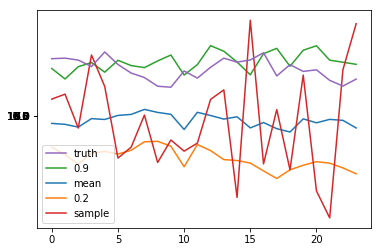

In [47]:
plot_series(result, 
           truth=True, 
           truth_data=truth_data, 
           truth_label='truth')

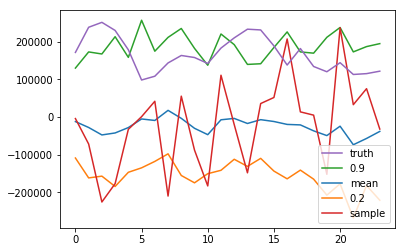

In [68]:
iq1 = '0.2'
iq2 = '0.9'
data = get_data_to_forecast(test_key)

historical_length = prediction_length*2

truth_data = data['target'][-prediction_length:]
historical_data = data['target'][-historical_length:-prediction_length]
cat = data['cat']
historical_start = ts_indexes[-(prediction_length*2)]

prediction_data = build_prediction_data(historical_start, historical_data, cat, iq1=iq1, iq2=iq2)

result = predictor.predict(prediction_data).decode('utf-8')

plot_series(result, 
           truth=True, 
           truth_data=truth_data, 
           truth_label='truth',
           iq1=iq1,
           iq2=iq2)

In [69]:
# clean up
print(job_name)
sm = boto3.client('sagemaker')
sm.delete_endpoint(EndpointName=job_name)
sm.delete_endpoint_config(EndpointConfigName=job_name)
sm.delete_model(ModelName=job_name)

POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554


{'ResponseMetadata': {'RequestId': '057cc2af-f76b-4a53-b8f7-4e69045cd036',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '057cc2af-f76b-4a53-b8f7-4e69045cd036',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 09 Jan 2019 08:47:01 GMT'},
  'RetryAttempts': 0}}

In [70]:
iq1 = '0.2'
iq2 = '0.9'
data = get_data_to_forecast(test_key)

historical_length = prediction_length*2

truth_data = data['target'][-prediction_length:]
historical_data = data['target'][-historical_length:-prediction_length]
cat = data['cat']
historical_start = ts_indexes[-(prediction_length*2)]

prediction_data = build_prediction_data(historical_start, historical_data, cat, iq1=iq1, iq2=iq2)

result = predictor.predict(prediction_data).decode('utf-8')

plot_series(result, 
           truth=True, 
           truth_data=truth_data, 
           truth_label='truth',
           iq1=iq1,
           iq2=iq2)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint POC-deepar-solar-forecast-model-2019-01-09-07-52-40-554 of account 547051082101 not found.